<center><img src='https://blog.gdeltproject.org/wp-content/uploads/2015-gdelt-2.png' width=400></center>

<strong>
Valentin LARRIEU <br>
Arnaud LEJEUNE <br>
Thomas MEIMOUN <br>
Thibault ROYER <br>
David TANG <br>
</strong>

In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from pymongo import MongoClient
from bson.son import SON
from pymongo import MongoClient
import time
import conda
import os
import seaborn as sns
sns.set(style='whitegrid')

#BaseMap
conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib
from mpl_toolkits.basemap import Basemap

In [2]:
start = time. time()

In [3]:
client = MongoClient('mongodb://localhost:8157/')

In [4]:
db = client['gdelt']
collection = db.actor_jun

<Strong>Fonction de Rename </strong>

In [5]:
path_country_code = "corresp_pays.csv"

In [6]:
df_country_code = pd.read_csv(path_country_code, low_memory=False, sep=",", dtype='object')

In [7]:
df_country_code = df_country_code.rename(columns={"code": 'Actor'}) # we rename the column for the join

In [8]:
def replace_by_correspondence(df, df_corresp, column_shared, index_column_replacer = 1, replace_nan = True):
    column_replacer = df_corresp.columns[index_column_replacer]
    dictionary = df_corresp.set_index(column_shared).to_dict()[column_replacer]
    df[column_shared + '_corresp'] = df[column_shared].map(dictionary)
    # We replace nan values by nothing
    if (replace_nan):
        df[column_shared + '_corresp'] = df[column_shared + '_corresp'].fillna("")
    return df

In [9]:
df_country_code.head()

,Actor,countryName
0,AF,Afghanistan
1,AX,Aland Islands
2,AL,Albania
3,AG,Algeria
4,AQ,American Samoa


# Part 1

display the number of articles/events there were for each triplet (day, country of the event, language of the article).

In [10]:
def Function1(correspondance=1):
    
    pipeline = [
    {"$group": {"_id":{"jour":"$SQLDATE", "actor":"$ActionGeo_CountryCode",
                       "langue":"$MentionDocTranslationInfo"}, "count": {"$sum":1}}}    
    ]
    
    result_query = pd.DataFrame(list(collection.aggregate(pipeline, allowDiskUse = True)))
    DF = pd.DataFrame()

    DF['Jour'] = pd.to_datetime(result_query.apply(lambda row : row["_id"]["jour"] , axis = 1), format='%Y%m%d')
    DF['Actor'] = result_query.apply(lambda row : row["_id"]["actor"] , axis = 1)
    DF['Langue'] = result_query.apply(lambda row : row["_id"]["langue"] , axis = 1)
    DF['Count'] = result_query['count']
    
    if correspondance == 1:
        DF=replace_by_correspondence(DF, df_country_code, 'Actor')
    
    return DF

def Triplet_Q1(Date, Actor, Langue, DF):

    return DF.loc[(DF["Actor"]==Actor) & (DF['Langue'] == Langue) & (DF['Jour'] == Date)].style.hide_index()

def Function1_count(jourTest, paysTest, langueTest):
    """sort uniquement le count pour un triplet"""
    
    pipeline = [
   {"$match": {"$and":[ {"SQLDATE": jourTest}, {"ActionGeo_CountryCode": paysTest},
                       {"MentionDocTranslationInfo": langueTest} ]}},
   {"$group": { "_id":{"jour":"$SQLDATE", "pays":"$ActionGeo_CountryCode",
                       "langue":"$MentionDocTranslationInfo"}, "count": {"$sum":1}}} 
    ]
    
    DF = pd.DataFrame(list(collection.aggregate(pipeline))).style.hide_index()
    
    return DF

In [11]:
DF_Q1 = Function1()
DF_Q1.sort_values(by=['Count'], ascending = False).head(10).style.hide_index()

Jour,Actor,Langue,Count,Actor_corresp
2018-06-20 00:00:00,US,ENG,186278,United States
2018-06-28 00:00:00,US,ENG,185906,United States
2018-06-27 00:00:00,US,ENG,185242,United States
2018-06-21 00:00:00,US,ENG,182456,United States
2018-06-06 00:00:00,US,ENG,180120,United States
2018-06-29 00:00:00,US,ENG,175938,United States
2018-06-22 00:00:00,US,ENG,174838,United States
2018-06-26 00:00:00,US,ENG,169592,United States
2018-06-19 00:00:00,US,ENG,167862,United States
2018-06-07 00:00:00,US,ENG,166098,United States


In [12]:
Triplet_Q1("2018-02-15", "US", "ENG", DF_Q1)

Jour,Actor,Langue,Count,Actor_corresp


In [14]:
Dataf = Function1_count(20180215, "US",  "ENG")
Dataf

# Part 2.

for an actor given as a parameter, display the events (values in the events table) that refer to it (in the last 6 months).

In [15]:
def Function2(TheName, Date=20180601):
    """Méthode simple poure requeter la Q2"""
    
    pipeline = [
    { 
        "$match" : { "$and": [{"SQLDATE":{"$gte":Date}}, {"ActorName" : TheName} ]}
    },
    { 
        "$group" : { 
            "_id" : {"globalEventId":"$GLOBALEVENTID", "date":"$SQLDATE", "actor":"$ActorName"}
        }
    }
    ]
    
    result_query = pd.DataFrame(list(collection.aggregate(pipeline, allowDiskUse = True)))
    DF = pd.DataFrame()
    
    DF['Date'] = pd.to_datetime(result_query.apply(lambda row : row["_id"]["date"] , axis = 1), format='%Y%m%d')
    DF['EventID'] = result_query.apply(lambda row : row["_id"]["globalEventId"] , axis = 1)
    DF['Actor'] = result_query.apply(lambda row : row["_id"]["actor"] , axis = 1)    
    
    return DF

In [16]:
DF_Q2 = Function2("BARACK OBAMA")
DF_Q2.sort_values(by=["Date"], ascending = False).head(10).style.hide_index()

Date,EventID,Actor
2018-06-30 00:00:00,768500375,BARACK OBAMA
2018-06-30 00:00:00,768418109,BARACK OBAMA
2018-06-30 00:00:00,768478850,BARACK OBAMA
2018-06-30 00:00:00,768412473,BARACK OBAMA
2018-06-30 00:00:00,768366192,BARACK OBAMA
2018-06-30 00:00:00,768540188,BARACK OBAMA
2018-06-30 00:00:00,768485771,BARACK OBAMA
2018-06-30 00:00:00,768530295,BARACK OBAMA
2018-06-30 00:00:00,768419983,BARACK OBAMA
2018-06-30 00:00:00,768538572,BARACK OBAMA


# Part 3.

find the subjects (actors) who had the most positive/negative articles for each triplet (month, country, language of the article).

In [18]:
def Function3():
    pipeline = [    
    {
        "$project": {
            "MonthYear": 1, "ActorName" : 1, "MentionDocTranslationInfo" : 1, "ActorGeo_CountryCode":1 ,
            "lessThan0": {  #// Set to 1 if AvgTone < 0
                "$cond": [ { "$lt": [ "$AvgTone", 0 ] }, 1, 0] #// MentionDocTone vs AvgTone ! 
            },
            "moreThan0": {  #// Set to 1 if AvgTone > 0
                "$cond": [ { "$gt": [ "$AvgTone", 0 ] }, 1, 0]
            }
        }
    },
    {
        "$group": {
            "_id": {"mois": "$MonthYear",  "actor":"$ActorName","langue":"$MentionDocTranslationInfo",
                    "pays":"$ActorGeo_CountryCode"}, 
                                                                                                                      #   // NE PAS FAIRE CA, EN GROUPANT PAR GLOBALEVENTID
            "countNegativeAvgTone" : { "$sum": "$lessThan0" }, 
            #Compte les AvgTone négatifs groupé par MonthYear, ActorCountryCode, MentionDocTranslationInfo
            "countPositiveAvgTone" : { "$sum": "$moreThan0" }
        }
    }]
    
    result_query = pd.DataFrame(list(collection.aggregate(pipeline, allowDiskUse = True)))
    DF = pd.DataFrame()
    
    DF['Date'] = pd.to_datetime(result_query.apply(lambda row : row["_id"]["mois"] , axis = 1), format='%Y%m')
    DF['Country'] = result_query.apply(lambda row : row["_id"]["pays"] , axis = 1)
    DF['Langue'] = result_query.apply(lambda row : row["_id"]["langue"] , axis = 1)
    DF['Actor'] = result_query.apply(lambda row : row["_id"]["actor"] , axis = 1)
    DF['#NegTone'] = result_query["countNegativeAvgTone"]
    DF['#PosTone'] = result_query["countPositiveAvgTone"]
    
    return DF

def Triplet_Q3(Month, Country, Langue, DF):
    
    return DF.loc[(DF["Country"]==Country) & (DF['Langue'] == Langue) & (DF['Date'].dt.month == Month)]


In [19]:
DF_Q3 = Function3()
DF_Q3.sort_values(by=["#NegTone"], ascending = False).head(10).style.hide_index()

Date,Country,Langue,Actor,#NegTone,#PosTone
2018-06-01 00:00:00,,ENG,,1558117,787592
2018-06-01 00:00:00,US,ENG,UNITED STATES,687051,291276
2018-06-01 00:00:00,,SPA,,320181,143546
2018-06-01 00:00:00,,RUS,,133052,49261
2018-06-01 00:00:00,,FRA,,109876,50475
2018-06-01 00:00:00,,ARA,,96889,52621
2018-06-01 00:00:00,CA,ENG,CANADA,73542,31971
2018-06-01 00:00:00,UK,ENG,UNITED KINGDOM,73097,50245
2018-06-01 00:00:00,US,ENG,POLICE,65530,3435
2018-06-01 00:00:00,IS,ENG,ISRAEL,61457,14653


In [20]:
Triplet_Q3(2, "US", "ENG", DF_Q3)

,Date,Country,Langue,Actor,#NegTone,#PosTone


# Part 4.

find out which actors/countries/organisations are the most divisive (e.g. had a positive perception in one part of the world and a negative perception in the rest of the world). Allow one aggregation per day/month/year.

In [21]:
def Function4(periodicity, correspondance=1):
    
    if periodicity == "Day":
        typeDate = "$SQLDATE"
    else:
        typeDate = "$MonthYear"
    
    pipeline = [
   {"$group": {
       "_id" : { "periode": typeDate, "actor": "$ActorGeo_CountryCode"},
       "ToneStd": {"$stdDevPop": "$AvgTone"}
       }
       }
    ]
    
    result_query = pd.DataFrame(list(collection.aggregate(pipeline, allowDiskUse = True)))
    DF = pd.DataFrame()
    
    if typeDate == "Day":
        DF['Date'] = pd.to_datetime(result_query.apply(lambda row : row["_id"]["periode"] , axis = 1), format='%Y%m%d')
    else:
        DF['Date'] = pd.to_datetime(result_query.apply(lambda row : row["_id"]["periode"] , axis = 1), format='%Y%m')
    
    DF['Actor'] = result_query.apply(lambda row : row["_id"]["actor"] , axis = 1)
    DF['ToneSTD'] = result_query["ToneStd"]
    
    if correspondance==1:
        DF=replace_by_correspondence(DF, df_country_code, 'Actor')
    
    return DF

DF_Q4 = Function4("Month")
DF_Q4.sort_values(by=["Date"], ascending = False).head(10).style.hide_index()

Date,Actor,ToneSTD,Actor_corresp
2018-06-01 00:00:00,LU,2.94039,Luxembourg
2018-06-01 00:00:00,CU,3.45535,Cuba
2018-06-01 00:00:00,MN,3.49561,Monaco
2018-06-01 00:00:00,LE,3.72739,Lebanon
2018-06-01 00:00:00,AM,3.73939,Armenia
2018-06-01 00:00:00,GH,3.92591,Ghana
2018-06-01 00:00:00,GL,2.68775,Greenland
2018-06-01 00:00:00,MA,3.64885,Madagascar
2018-06-01 00:00:00,RQ,3.44086,Puerto Rico
2018-06-01 00:00:00,TW,3.12743,Taiwan


In [22]:
DF_Q4.sort_values(by=["ToneSTD"], ascending = False).head(30).style.hide_index()

Date,Actor,ToneSTD,Actor_corresp
2017-06-01 00:00:00,FM,9.70697,Micronesia
2018-05-01 00:00:00,ER,9.24233,Eritrea
2017-06-01 00:00:00,MO,7.06373,Morocco
2017-06-01 00:00:00,UZ,6.42937,Uzbekistan
2017-06-01 00:00:00,SW,6.07798,Sweden
2008-06-01 00:00:00,RP,5.92932,Philippines
2017-06-01 00:00:00,FI,5.68876,Finland
2017-06-01 00:00:00,BF,5.53772,Bahamas
2017-06-01 00:00:00,AG,5.46827,Algeria
2018-06-01 00:00:00,BA,5.3426,Bahrain


In [23]:
def Wrong_Function4():
    
    pipeline4 = [
    {"$project": {
        "ActorName": 1, "SQLDATE": 1, "AvgTone": 1,
        "hemisphereNordAvgTone": {"$cond": [{"$gt": ["$ActorGeo_Lat", 0]}, "$AvgTone", 0]},
        "hemisphereSudAvgTone": {"$cond": [{"$lt": ["$ActorGeo_Lat", 0]}, "$AvgTone", 0]}
        }
    },
    {"$group": {
        "_id": {"actor":"$ActorName", "date": "$SQLDATE"},
        "hemisphereNordAvgToneMean": {"$avg": "$hemisphereNordAvgTone"},
        "hemisphereSudAvgToneMean": {"$avg": "$hemisphereSudAvgTone"}
        }
    },
    {"$project": {
        "hemisphereNordAvgToneMean": 1, "hemisphereSudAvgToneMean": 1,
        "deltaEntreHemispheresNordSud": {"$abs": {"$subtract": ["$hemisphereNordAvgToneMean", "$hemisphereSudAvgToneMean"]}} #// Magnitude entre moyennes AvgTone des hemisphères Nord et Sud
            }
    }
    ]
    
    result_query4 = pd.DataFrame(list(collection.aggregate(pipeline4, allowDiskUse = True)))
    df4 = pd.DataFrame()
    
    df4['Date'] = pd.to_datetime(result_query4.apply(lambda row : row["_id"]["date"] , axis = 1), format='%Y%m%d')
    df4['Actor'] = result_query4.apply(lambda row : row["_id"]["actor"] , axis = 1)
    df4['DifferenceHemisphere'] = result_query4["deltaEntreHemispheresNordSud"]
    df4['North_Avg_Tone'] = result_query4["hemisphereNordAvgToneMean"]
    df4['South_Avg_Tone'] = result_query4["hemisphereSudAvgToneMean"]
    
    return df4

wrong_Q4 = Wrong_Function4()
wrong_Q4.sort_values(by=["DifferenceHemisphere"], ascending = False).head(10).style.hide_index()

Date,Actor,DifferenceHemisphere,North_Avg_Tone,South_Avg_Tone
2018-10-16 00:00:00,CONMAN,25.641,-25.641,0
2018-12-01 00:00:00,UKRAIN,25,-25,0
2018-06-20 00:00:00,CORINTH,24.1282,-24.1282,0
2018-10-04 00:00:00,TONGAN,23.4043,0,23.4043
2017-04-09 00:00:00,CANBERRA,23.2285,0,-23.2285
2018-07-13 00:00:00,KOLN,23.0216,0,-23.0216
2018-02-08 00:00:00,FEDERATED STATES OF MICRONESIA,22.9592,-22.9592,0
2017-04-25 00:00:00,CINCINNATI,22.7273,-22.7273,0
2017-04-15 00:00:00,MARYLAND,22.7273,-22.7273,0
2018-03-27 00:00:00,ESFAHAN,22.6415,-22.6415,0


In [37]:
wrong_Q4.to_csv('wrong_Q4.csv')

# Bonus

It will allow us to better understand the evolution of the relations between the different countries, by studying the tone of the mentions (positive/negative) in the media articles of each country.

In [23]:
def Function_Bonus_pt1(paysTest1, paysTest2, anneeTest):

    pipeline = [
    {"$match" :
       {"$or" :
           [
           {"$and": [{"ActorGeo_CountryCode": paysTest1},{"Year": anneeTest}] },
           {"$and": [{"ActorGeo_CountryCode": paysTest2},{"Year": anneeTest}] }
           ]
       }
    },
    {"$group" : {
       "_id" : {"fractionDate": "$FractionDate","globalEventId": "$GLOBALEVENTID", "actor": "$ActorGeo_CountryCode"},
       "avgToneMean": {"$avg": "$AvgTone"}
       }
    }        
    ]
    
    result_query = pd.DataFrame(list(collection.aggregate(pipeline, allowDiskUse = True)))
    
    DF = pd.DataFrame()
    
    DF['FracDate'] = result_query.apply(lambda row : row["_id"]["fractionDate"] , axis = 1)
    DF['EventID'] = result_query.apply(lambda row : row["_id"]["globalEventId"] , axis = 1)
    DF['AvgTone'] = result_query["avgToneMean"]
    DF['Actor'] = result_query.apply(lambda row : row["_id"]["actor"] , axis = 1)
    
    return DF

In [24]:
DF_bon11 = Function_Bonus_pt1("FR", "EN", 2018)
DF_bon12 = Function_Bonus_pt1("CH", "RS", 2018)


frames = [DF_bon11, DF_bon12]

DF_bon111 = pd.concat(frames, axis=0)

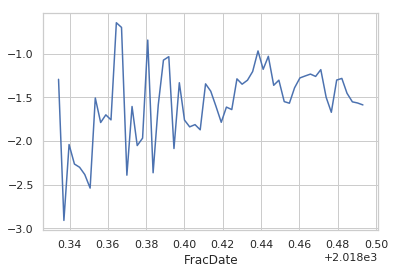

In [25]:
DF_bon111.groupby("FracDate")["AvgTone"].mean().plot()

/home/arnaud/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:851: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


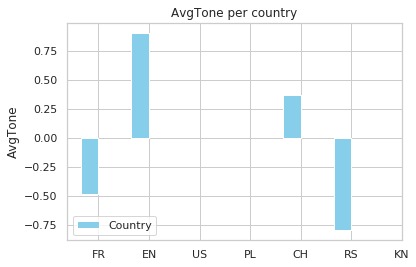

In [26]:
df_country = DF_bon111.groupby("Actor")["AvgTone"].mean()
countries = ["FR","EN","US","PL","CH","RS","KN"]
selected_country = df_country[countries]
ind = np.arange(len(selected_country))  # the x locations for the groups
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, selected_country - df_country.mean(), width,
                color='SkyBlue', label='Country')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('AvgTone')
ax.set_title('AvgTone per country')
ax.set_xticks(ind)
ax.set_xticklabels(("FR","EN","US","PL","CH","RS","KN"))
ax.legend()
def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.
    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """
    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off
    for rect in rects:
        height = rect.get_height()
autolabel(rects1, "left")
plt.show()

In [27]:
def Function_Bonus_pt2(moisTest):


    result_query = pd.DataFrame(list(collection.find( {"MonthYear":moisTest},
                                                   {"AvgTone":1, "ActionGeo_Lat":1, "ActionGeo_Long":1})))
    
    DF = pd.DataFrame()
    
    DF['AvgTone'] = result_query.apply(lambda row : row["AvgTone"] , axis = 1)
    DF['ActionGeo_Lat'] = result_query.apply(lambda row : row["ActionGeo_Lat"] , axis = 1)
    DF['ActionGeo_Long'] = result_query.apply(lambda row : row["ActionGeo_Long"] , axis = 1)
    
    return DF

In [28]:
DF_bon2 = Function_Bonus_pt2(201801)
DF_bon2

ValueError: Wrong number of items passed 0, placement implies 1

In [ ]:
# base map 
np_bon2 = np.array(DF_bon2)

maxTone = np.max(DF_bon2["AvgTone"])
minTone = np.min(DF_bon2["AvgTone"])

def avgToColor(avgTone):
    red = 0.5 - avgTone/(-minTone)
    red = max(min(red,1),0)
    green = 0.5 + avgTone/(maxTone)
    green = max(min(green,1),0)
    return red, green

plt.figure(figsize=(20,20))
m = Basemap(projection='mill',lon_0=0,resolution='c')
m.drawcoastlines()
m.fillcontinents(color='gray',lake_color='white')
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,120.,30.))
m.drawmeridians(np.arange(0.,420.,60.))
# draw a black dot at the center.

for avgTone, lat, lon in np_bon2[:10000]:
    xpt, ypt = m(lon, lat)
    red, green = avgToColor(avgTone)
    print(red, green)
    m.plot([xpt],[ypt], color=((red,green,0,1)))
    
# draw the title.
plt.title('Azimuthal Equidistant Projection')
plt.show()

In [ ]:
end = time. time()
print(end - start)